In [377]:
import nibabel as nib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import pandas as pd
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [121]:
base_path = '/Users/ahmet/Desktop/Study/second_semester/ds_project/BSNIP/pconn'

In [120]:
pconn_paths = os.listdir('/Users/ahmet/Desktop/Study/second_semester/ds_project/BSNIP/pconn')

In [98]:
session_ids = [path.split('.')[0] for path in pconn_paths]

In [88]:
behavior_path = '/Users/ahmet/Desktop/Study/second_semester/ds_project/behavior/'

In [126]:
def read_behavior(path):
    # Reading
    behavior_path = path
    
    behavior_files = os.listdir(behavior_path)
    
    behavior_source = pd.read_csv(behavior_path+behavior_files[0], sep='\t')
    for behavior_file in behavior_files[1:]:
        curr_behavior_source = pd.read_csv(behavior_path+behavior_file, sep='\t')
        behavior_source = pd.concat([behavior_source, curr_behavior_source], axis=0)

    return behavior_source

def read_pconn(path):
    
    # Load the .pconn.nii file
    img = nib.load(path)
    
    # Extract the data array from the image
    # The data might need to be processed or reshaped depending on its structure
    data = img.get_fdata()

    df = pd.DataFrame(data)
    
    return data, df

def build_network(data, df, visualize = True):
    # Create a graph from the data
    # This example assumes 'data' is a square matrix where data[i][j] represents the connection
    # strength between region i and region j. Your data's structure may vary.
    G = nx.Graph()
    
    # Add nodes with the brain region names or indices if you don't have names
    num_regions = data.shape[0]
    G.add_nodes_from(range(num_regions))
    
    # Add edges based on connectivity data
    # Here we're simply adding an edge for every non-zero connection
    for i in range(num_regions):
        # Calculate the standard deviation of the specified row
        std_dev = df.iloc[i].std()
        threshold = 2*std_dev
        for j in range(i+1, num_regions):  # Ensure i < j to avoid duplicating edges
            if abs(data[i, j]) > threshold:  # Assuming 0 means no connection
                G.add_edge(i, j, weight=data[i, j])
    
    if visualize:
        # You can also visualize the graph using matplotlib or similar libraries
        # This step requires matplotlib to be installed (`pip install matplotlib`)
        nx.draw(G, with_labels=True)
        plt.show()
        
    return G

def graph_stats(session_id, G):
    clustering = nx.average_clustering(G)
    edges = G.number_of_edges()
    density = nx.density(G)
    #diameter = nx.diameter(G)
    # min max degree
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    num_connected_components = len(list(nx.connected_components(G)))
    
    stats_dict = {'session_id': session_id,
                'avg_clustering': clustering,
                 'num_of_edges':edges,
                 'denstity': density,
                 #'diameter' : diameter,
                 'max_degree' : dmax,
                'min_degree' : dmin,
                'num_connected_components': num_connected_components}
    
    return stats_dict

In [101]:
df_behavior = read_behavior(behavior_path)
df_behavior

,session_id,Group,BACS_Dig_Seq_z,BACS_Sym_Cod_z,BACS_Tok_Mot_z,BACS_Tower_z,BACS_Verb_Flu_z,BACS_Verb_Mem_z,PANSS_p1,PANSS_p2,...,PANSS_g7,PANSS_g8,PANSS_g9,PANSS_g10,PANSS_g11,PANSS_g12,PANSS_g13,PANSS_g14,PANSS_g15,PANSS_g16
0,S9872THQ1,CON,-1.029762,-0.033421,-2.678832,0.077206,-0.515179,-1.722595,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0,S7601YAH1,SADP,-0.136905,-1.000880,-2.313869,0.077206,0.128795,-0.380313,2.0,1.0,...,4.0,1.0,2.0,1.0,2.0,1.0,3.0,3.0,1.0,3.0
0,S3478UPA1,CON,-1.922619,-0.912929,-2.313869,-1.761029,-1.067157,-2.058166,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0,S8036VCK3,BPP,-1.070388,-0.250962,-0.423391,-0.330508,-0.924242,-1.554610,3.0,2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
0,S9134FMR1,BPP,0.143204,-0.924038,-2.055304,-0.754237,0.496212,0.289362,3.0,2.0,...,1.0,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,S8320GAY1,CON,0.871359,1.191346,-2.055304,1.788136,0.117424,0.714894,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0,S3084TET1,BPP,-0.099515,-1.500962,0.301904,-0.330508,0.875000,-0.703546,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0,S4885JYP1,CON,-1.378151,-0.143236,-1.285204,-0.079002,0.066210,-2.262394,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0,S7110LVJ1,CON,1.142857,1.536693,0.144389,1.168399,0.370624,1.002418,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [135]:
stats = []
for session_id, pconn_path in zip(session_ids, pconn_paths):
    path = os.path.join(base_path, pconn_path)
    data, df = read_pconn(path)
    G = build_network(data, df, visualize = False)
    stats_dict = graph_stats(session_id, G)
    stats.append(stats_dict)

In [136]:
df_stats = pd.DataFrame(stats)

In [146]:
df = df_behavior.merge(df_stats, how = 'left', on = 'session_id')

In [156]:
df.head()

,session_id,Group,BACS_Dig_Seq_z,BACS_Sym_Cod_z,BACS_Tok_Mot_z,BACS_Tower_z,BACS_Verb_Flu_z,BACS_Verb_Mem_z,PANSS_p1,PANSS_p2,...,PANSS_g13,PANSS_g14,PANSS_g15,PANSS_g16,avg_clustering,num_of_edges,denstity,max_degree,min_degree,num_connected_components
0,S9872THQ1,CON,-1.029762,-0.033421,-2.678832,0.077206,-0.515179,-1.722595,1.0,1.0,...,1.0,1.0,1.0,1.0,0.398859,26945,0.104680,262,5,1
1,S7601YAH1,SADP,-0.136905,-1.000880,-2.313869,0.077206,0.128795,-0.380313,2.0,1.0,...,3.0,3.0,1.0,3.0,0.305384,13193,0.051254,99,7,1
2,S3478UPA1,CON,-1.922619,-0.912929,-2.313869,-1.761029,-1.067157,-2.058166,1.0,1.0,...,1.0,1.0,1.0,1.0,0.451101,34639,0.134571,294,5,1
3,S8036VCK3,BPP,-1.070388,-0.250962,-0.423391,-0.330508,-0.924242,-1.554610,3.0,2.0,...,2.0,2.0,2.0,2.0,0.228684,4506,0.017506,61,0,113
4,S9134FMR1,BPP,0.143204,-0.924038,-2.055304,-0.754237,0.496212,0.289362,3.0,2.0,...,3.0,1.0,1.0,3.0,0.370967,21618,0.083985,197,2,1


In [437]:
labels, counts = np.unique(y_train, return_counts=True)
count_per_class = dict(zip(labels, counts))

In [463]:
X = df.drop(['Group', 'session_id'], axis=1)
y = df['Group']

le = LabelEncoder()
encoded_y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(objective='multi:softmax', max_depth = 4, reg_lambda = 50, n_estimators=50, eta = 0.0001, seed=11)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.0001, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [464]:
preds = model.predict(X_test)

In [465]:
pred_train = model.predict(X_train)

In [466]:
print('Train accuracy {}'.format(accuracy_score(y_train, pred_train)))

Train accuracy 0.7686274509803922


In [467]:
print('Test accuracy {}'.format(accuracy_score(y_test, preds)))

Test accuracy 0.765625


Parameter tuning and scale_pos_weight (for data imbalance) parameter can be tried.

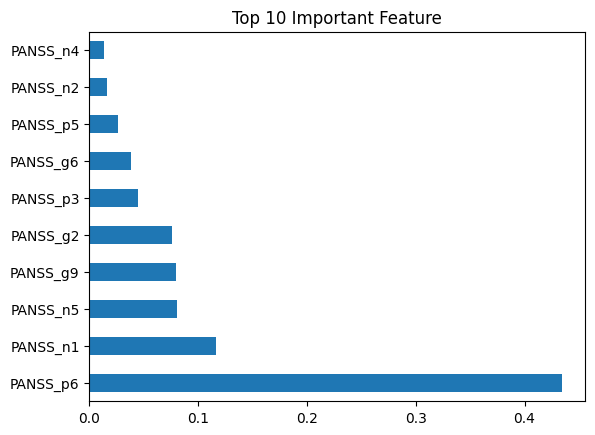

In [487]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending = False)
feat_imp[:10].plot(kind = 'barh')
plt.title('Top 10 Important Feature')
plt.show()

In [488]:
feat_imp

PANSS_p6                    0.434193
PANSS_n1                    0.116852
PANSS_n5                    0.080942
PANSS_g9                    0.079998
PANSS_g2                    0.076271
PANSS_p3                    0.044404
PANSS_g6                    0.038173
PANSS_p5                    0.026553
PANSS_n2                    0.015886
PANSS_n4                    0.013543
BACS_Dig_Seq_z              0.012726
PANSS_g12                   0.010738
PANSS_p1                    0.007732
PANSS_g13                   0.006936
PANSS_p4                    0.006453
PANSS_p7                    0.005020
BACS_Tok_Mot_z              0.003093
PANSS_p2                    0.003033
BACS_Verb_Mem_z             0.002927
BACS_Sym_Cod_z              0.002743
BACS_Tower_z                0.002607
PANSS_g1                    0.002478
PANSS_g7                    0.002465
BACS_Verb_Flu_z             0.002275
avg_clustering              0.001130
PANSS_g16                   0.000402
PANSS_n3                    0.000275
P

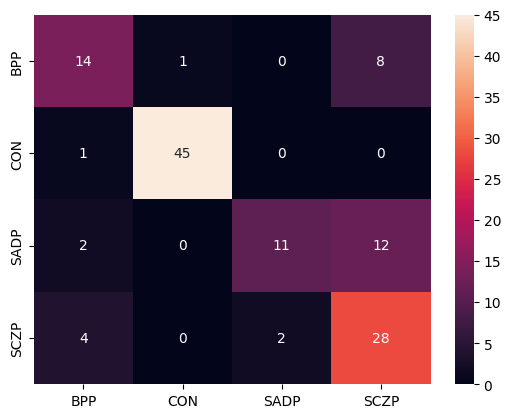

In [468]:
sns.heatmap(confusion_matrix(y_test, preds), annot = True, xticklabels = le.classes_, yticklabels = le.classes_);